# ModelX - Team Steven

## Import Libraries

In [31]:
!pip install pandas numpy matplotlib seaborn xgboost catboost lightgbm optuna catboost

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score


## Dataset Loading

In [63]:
df=pd.read_csv("Dementia Prediction Dataset.csv")
print(df.shape)
print(df.head())
print(df.columns)
print(df.dtypes)


/tmp/ipython-input-928608605.py:1: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("Dementia Prediction Dataset.csv")


(195196, 1024)
       NACCID  NACCADC PACKET  FORMVER  VISITMO  VISITDAY  VISITYR  NACCVNUM  \
0  NACC002909      186      I      3.0       12        28     2022         1   
1  NACC002909      186      F      3.0        1        23     2024         2   
2  NACC003487      186      I      3.0       11        15     2023         1   
3  NACC004352      186      I      3.0       10         5     2021         1   
4  NACC004687      186      I      3.0       11        14     2022         1   

   NACCAVST  NACCNVST  ...  NPATGAM1  NPATGAM2  NPATGAM3  NPATGAM4  NPATGAM5  \
0         2         2  ...        -4        -4        -4        -4        -4   
1         2         2  ...        -4        -4        -4        -4        -4   
2         1         1  ...        -4        -4        -4        -4        -4   
3         1         1  ...        -4        -4        -4        -4        -4   
4         1         1  ...        -4        -4        -4        -4        -4   

   NPATGFRN  NPATGFR1  

## Feature Selection

In [64]:
selected_cols=[
"NACCAGE","SEX","EDUC","MARISTAT","NACCLIVS",
"NACCFAM","NACCMOM","NACCDAD",
"ANYMEDS","NACCAMD",
"NACCAHTN","NACCHTNC","NACCACEI","NACCAAAS","NACCBETA","NACCCCBS","NACCDIUR","NACCVASD",
"NACCANGI","NACCLIPL","NACCNSD","NACCAC","NACCADEP","NACCAPSY","NACCAANX","NACCADMD",
"NACCPDMD","NACCEMD","NACCEPMD","NACCDBMD",
"TOBAC30","TOBAC100","SMOKYRS","PACKSPER","QUITSMOK","ALCOCCAS","ALCFREQ",
"DIABETES","HYPERTEN","HYPERCHO","CBSTROKE","HXSTROKE","CVAFIB","CVCHF",
"PD","TBI","APNEA","RBD","INSOMN","B12DEF","THYROID","DEP2YRS","DEPOTHR","ANXIETY",
"INDEPEND","DECSUB","BILLS","REMDATES","WEIGHT","NACCBMI","VISION","HEARING"
]
X= df[selected_cols]
y=df['DEMENTED']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_sample,_,y_sample,_=train_test_split(X_train, y_train, train_size=30000, random_state=0)  # 10% sample for feature selection

In [65]:
print(X_train.shape)
print(X_test.shape)

(156156, 62)
(39040, 62)


In [66]:
change_case_cols = X.select_dtypes(include=['object','string']).columns
X[change_case_cols] = X[change_case_cols].applymap(lambda x: x.lower() if isinstance(x, str) else x)

/tmp/ipython-input-4170538118.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X[change_case_cols] = X[change_case_cols].applymap(lambda x: x.lower() if isinstance(x, str) else x)


## Preprocessing

In [67]:
numerical_cols=X.select_dtypes(exclude=['object'])
categorical_cols=X.select_dtypes(include=['object'])
low_cardinality_cols=categorical_cols[[col for col in categorical_cols.columns if categorical_cols[col].nunique()<5]]
high_cardinality_cols=categorical_cols[[col for col in categorical_cols.columns if categorical_cols[col].nunique()>=5]]

In [68]:
numerical_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy='constant',fill_value=0)),
    ("scaler",StandardScaler())
])
categorical_transformer=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value='missing_value')),
    ('to_string', FunctionTransformer(lambda X: X.astype(str))),
    ('ordinal',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))
])
preprocessor=ColumnTransformer(transformers=[
    ('num',numerical_transformer,numerical_cols.columns),
    ('cat',categorical_transformer,categorical_cols.columns)
])

## Model Development

### Random Forest Classifier

In [69]:
model_rf=Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('model',RandomForestClassifier())
])

In [70]:
param_distributions = {
    "model__n_estimators": randint(50, 300),
    "model__max_depth": [None, 5, 10, 15, 20],
    "model__min_samples_split": randint(2, 11),
    "model__min_samples_leaf": randint(1, 6),
    "model__max_features": ["sqrt", "log2", None, 0.5],
    "model__criterion": ["gini", "entropy"],
    "model__class_weight": [None, "balanced"]
}

In [71]:
random_search_rf = HalvingRandomSearchCV(
    estimator=model_rf,
    param_distributions=param_distributions,
    n_candidates=20,
    cv=3,
    scoring="accuracy",
    random_state=0
)

random_search_rf.fit(X_sample, y_sample)

HalvingRandomSearchCV(cv=3,
                      estimator=Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value=0,
                                                                                                                 strategy='constant')),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  Index(['NACCAGE', 'SEX', 'EDUC', 'MARISTAT', 'NACCLIVS', 'NACCFAM', 'NACCMOM',
       'NACCDAD', 'ANYMEDS', 'NACCAMD', 'NACCAHTN', 'NACCHTNC', 'NACCACEI',
       '...
                                                                   'log2', None,
                                                                   0.5],
                                           'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a75c8269ca0>,
                                           'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a75c8268830>,
                                           'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a75c8268950>},
                      random_state=0, scoring='accuracy')

In [72]:
print("Best Parameters:", random_search_rf.best_params_)
print("Best CV Accuracy:", random_search_rf.best_score_)

Best Parameters: {'model__class_weight': None, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 0.5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 4, 'model__n_estimators': 149}
Best CV Accuracy: 0.9444444444444445


In [74]:
# Remove the "model__" prefix from best_params_ automatically
final_model_params = {
    key.replace("model__", ""): value
    for key, value in random_search_rf.best_params_.items()
}

# Build final model
final_model_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(**final_model_params))
])

In [75]:
final_model_rf.fit(X_train,y_train)
preds_rf=final_model_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds_rf))

Accuracy: 0.9310963114754098


### XGBoost Classifier

In [98]:
model_xgb=Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('model',XGBClassifier(n_jobs=-1, use_label_encoder=False, eval_metric='logloss'))
])

param_distributions = {
    "model__n_estimators": randint(100, 400),
    "model__learning_rate": uniform(0.01, 0.3),
    "model__max_depth": randint(3, 10),
    "model__subsample": uniform(0.7, 0.3),
    "model__colsample_bytree": uniform(0.7, 0.3)
}

random_search_xgb = HalvingRandomSearchCV(
    estimator=model_xgb,
    param_distributions=param_distributions,
    n_candidates=20,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=0
)

random_search_xgb.fit(X_sample, y_sample)

print("Best Parameters:", random_search_xgb.best_params_)
print("Best CV Accuracy:", random_search_xgb.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 8
min_resources_: 12
max_resources_: 30000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 20
n_resources: 12
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 7
n_resources: 36
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 2
n_candidates: 3
n_resources: 108
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:25:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'model__colsample_bytree': np.float64(0.9595307683916154), 'model__learning_rate': np.float64(0.16269068820010435), 'model__max_depth': 9, 'model__n_estimators': 141, 'model__subsample': np.float64(0.9763472830711599)}
Best CV Accuracy: 0.9351851851851851


In [102]:
final_model_params = {
    key.replace("model__", ""): value
    for key, value in random_search_rf.best_params_.items()
}

# Build final model
final_model_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(**final_model_params))
])

final_model_xgb.fit(X_train, y_train)

preds_xgb=final_model_xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds_xgb))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:29:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9321721311475409


### CatBoost Classifier

In [89]:
param_dist = {
    'model__iterations': [200, 300, 500],
    'model__learning_rate': [0.01, 0.03, 0.1, 0.2],
    'model__depth': [4, 6, 8, 10],
    'model__l2_leaf_reg': [1, 3, 5, 10, 20],
    'model__bagging_temperature': [0, 0.5, 1],
    'model__random_strength': [0.5, 1, 2]
}

model_ctb=Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('model',CatBoostClassifier(verbose=0,thread_count=1))
])

random_search_ctb = HalvingRandomSearchCV(
    estimator=model_ctb,
    param_distributions=param_dist,
    n_candidates=50,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=0
)

random_search_ctb.fit(X_sample, y_sample)
print("Best params:", random_search_ctb.best_params_)
print("Best CV Accuracy:", random_search_ctb.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 8
min_resources_: 12
max_resources_: 30000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 50
n_resources: 12
Fitting 3 folds for each of 50 candidates, totalling 150 fits
----------
iter: 1
n_candidates: 17
n_resources: 36
Fitting 3 folds for each of 17 candidates, totalling 51 fits
----------
iter: 2
n_candidates: 6
n_resources: 108
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 3
n_candidates: 2
n_resources: 324
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params: {'model__random_strength': 2, 'model__learning_rate': 0.01, 'model__l2_leaf_reg': 3, 'model__iterations': 500, 'model__depth': 10, 'model__bagging_temperature': 0}
Best CV Accuracy: 0.9413580246913581


In [99]:
final_model_params = {
    key.replace("model__", ""): value
    for key, value in random_search_ctb.best_params_.items()
}

final_model_ctb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", CatBoostClassifier(**final_model_params, verbose=0))
])

final_model_ctb.fit(X_train,y_train)
preds_ctb=final_model_ctb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds_ctb))

Accuracy: 0.9307633196721311


LightGBM Classifier

In [76]:
### LightGBM Classifier

from lightgbm import LGBMClassifier

# LightGBM Model Pipeline
model_lgbm = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LGBMClassifier(objective='binary'))
])

# Hyperparameter search space
param_distributions_lgbm = {
    "model__n_estimators": randint(200, 1000),
    "model__learning_rate": uniform(0.01, 0.2),
    "model__max_depth": randint(-1, 12),
    "model__num_leaves": randint(20, 200),
    "model__subsample": uniform(0.6, 0.4),
    "model__colsample_bytree": uniform(0.6, 0.4),
    "model__reg_alpha": uniform(0, 10),
    "model__reg_beta": uniform(0, 10)
}

# Halving Random Search
random_search_lgbm = HalvingRandomSearchCV(
    estimator=model_lgbm,
    param_distributions=param_distributions_lgbm,
    n_candidates=30,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=0
)

# Fit search on sample
random_search_lgbm.fit(X_sample, y_sample)

print("Best Parameters:", random_search_lgbm.best_params_)
print("Best CV Accuracy:", random_search_lgbm.best_score_)

# Clean parameter dictionary (remove model__ prefix)
final_model_params_lgbm = {
    key.replace("model__", ""): value
    for key, value in random_search_lgbm.best_params_.items()
}

# Final LightGBM Model
final_model_lgbm = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LGBMClassifier(**final_model_params_lgbm))
])

# Train
final_model_lgbm.fit(X_train, y_train)

# Predict
preds_lgbm = final_model_lgbm.predict(X_test)

print("LightGBM Accuracy:", accuracy_score(y_test, preds_lgbm))


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 8
min_resources_: 12
max_resources_: 30000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 30
n_resources: 12
Fitting 3 folds for each of 30 candidates, totalling 90 fits
----------
iter: 1
n_candidates: 10
n_resources: 36
Fitting 3 folds for each of 10 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 4
n_resources: 108
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 3
n_candidates: 2
n_resources: 324
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Number of positive: 8805, number of negative: 21195
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.9316598360655738


Logistic Rereession Classifier

In [80]:
### Logistic Regression Classifier

from sklearn.linear_model import LogisticRegression

# Logistic Regression Pipeline
model_lr = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(
            solver='lbfgs',
            max_iter=2000
        ))
])

# Hyperparameter search space
param_distributions_lr = {
    "model__penalty": ["l2", None],
    "model__C": uniform(0.001, 10),              # Regularization strength
    "model__class_weight": [None, "balanced"],   # Handle imbalance
    "model__fit_intercept": [True, False]
}

# Halving Random Search
random_search_lr = HalvingRandomSearchCV(
    estimator=model_lr,
    param_distributions=param_distributions_lr,
    n_candidates=20,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=0
)

# Fit search
random_search_lr.fit(X_sample, y_sample)

print("Best Parameters:", random_search_lr.best_params_)
print("Best CV Accuracy:", random_search_lr.best_score_)

# Remove "model__" prefix
final_model_params_lr = {
    key.replace("model__", ""): value
    for key, value in random_search_lr.best_params_.items()
}

# Final Logistic Regression model
final_model_lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=2000,      # keep high iteration limit
        **final_model_params_lr
    ))
])

# Train
final_model_lr.fit(X_train, y_train)

# Predict
preds_lr = final_model_lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, preds_lr))


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 8
min_resources_: 12
max_resources_: 30000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 20
n_resources: 12
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 7
n_resources: 36
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 2
n_candidates: 3
n_resources: 108
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'model__C': np.float64(0.9938035035897387), 'model__class_weight': 'balanced', 'model__fit_intercept': False, 'model__penalty': 'l2'}
Best CV Accuracy: 0.851851851851852
Logistic Regression Accuracy: 0.902484631147541


**HistGradientBoosting Classifier**

In [92]:
### HistGradientBoosting Classifier

from sklearn.ensemble import HistGradientBoostingClassifier

# HistGradientBoosting Pipeline
model_hgb = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', HistGradientBoostingClassifier(
            loss='log_loss'        # Binary classification loss
        ))
])

# Hyperparameter search space
param_distributions_hgb = {
    "model__learning_rate": uniform(0.01, 0.2),
    "model__max_depth": randint(3, 20),
    "model__max_bins": randint(50, 255),       # More bins → more expressive
    "model__l2_regularization": uniform(0, 5),
    "model__min_samples_leaf": randint(20, 200),
    "model__max_leaf_nodes": randint(20, 200)
}

# Halving Random Search
random_search_hgb = HalvingRandomSearchCV(
    estimator=model_hgb,
    param_distributions=param_distributions_hgb,
    n_candidates=30,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=0
)

# Fit search on sample
random_search_hgb.fit(X_sample, y_sample)

print("Best Parameters:", random_search_hgb.best_params_)
print("Best CV Accuracy:", random_search_hgb.best_score_)

# Remove prefix
final_model_params_hgb = {
    key.replace("model__", ""): value
    for key, value in random_search_hgb.best_params_.items()
}

# Final model
final_model_hgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", HistGradientBoostingClassifier(
        loss='log_loss',
        **final_model_params_hgb
    ))
])

# Train final model
final_model_hgb.fit(X_train, y_train)

# Predictions
preds_hgb = final_model_hgb.predict(X_test)

print("HistGradientBoosting Accuracy:", accuracy_score(y_test, preds_hgb))


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 8
min_resources_: 12
max_resources_: 30000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 30
n_resources: 12
Fitting 3 folds for each of 30 candidates, totalling 90 fits
----------
iter: 1
n_candidates: 10
n_resources: 36
Fitting 3 folds for each of 10 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 4
n_resources: 108
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 3
n_candidates: 2
n_resources: 324
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'model__l2_regularization': np.float64(2.8498245535063242), 'model__learning_rate': np.float64(0.12817455224963464), 'model__max_bins': 168, 'model__max_depth': 15, 'model__max_leaf_nodes': 145, 'model__min_samples_leaf': 44}
Best CV Accuracy: 0.9290123456790124
HistGradientBoosting Accuracy: 0.9323002049180328


**SVM Model**

In [83]:
### Linear SVM (LinearSVC)

from sklearn.svm import LinearSVC

# Linear SVC Pipeline
model_linsvc = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LinearSVC())
])

# Hyperparameter search space
param_distributions_linsvc = {
    "model__C": uniform(0.001, 10),            # Regularization strength
    "model__loss": ["hinge", "squared_hinge"], # SVM loss functions
    "model__class_weight": [None, "balanced"], # Handle imbalance
    "model__fit_intercept": [True, False]
}

# Halving Random Search
random_search_linsvc = HalvingRandomSearchCV(
    estimator=model_linsvc,
    param_distributions=param_distributions_linsvc,
    n_candidates=25,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=0
)

# Fit on sample (faster)
random_search_linsvc.fit(X_sample, y_sample)

print("Best Parameters:", random_search_linsvc.best_params_)
print("Best CV Accuracy:", random_search_linsvc.best_score_)

# Remove "model__" prefix
final_model_params_linsvc = {
    key.replace("model__", ""): value
    for key, value in random_search_linsvc.best_params_.items()
}

# Final model
final_model_linsvc = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearSVC(
        **final_model_params_linsvc
    ))
])

# Train final model
final_model_linsvc.fit(X_train, y_train)

# Predict
preds_linsvc = final_model_linsvc.predict(X_test)

print("Linear SVC Accuracy:", accuracy_score(y_test, preds_linsvc))


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 8
min_resources_: 12
max_resources_: 30000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 25
n_resources: 12
Fitting 3 folds for each of 25 candidates, totalling 75 fits
----------
iter: 1
n_candidates: 9
n_resources: 36
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 2
n_candidates: 3
n_resources: 108
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best Parameters: {'model__C': np.float64(4.144685882263688), 'model__class_weight': None, 'model__fit_intercept': False, 'model__loss': 'hinge'}
Best CV Accuracy: 0.861111111111111
Linear SVC Accuracy: 0.8981557377049181


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**ExtraTrees Classifier**

In [86]:
from sklearn.ensemble import ExtraTreesClassifier

# -----------------------------
# 1. Define ExtraTrees Pipeline
# -----------------------------
model_et = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ExtraTreesClassifier(random_state=0, n_jobs=-1))
])

# -----------------------------
# 2. Hyperparameter search space
# -----------------------------
param_distributions_et = {
    "model__n_estimators": randint(100, 500),
    "model__max_depth": [None, 5, 10, 15, 20],
    "model__min_samples_split": randint(2, 11),
    "model__min_samples_leaf": randint(1, 6),
    "model__max_features": ["sqrt", "log2", None, 0.5],
    "model__bootstrap": [True, False],
    "model__criterion": ["gini", "entropy"],
    "model__class_weight": [None, "balanced"]
}

# -----------------------------
# 3. Halving Random Search
# -----------------------------
random_search_et = HalvingRandomSearchCV(
    estimator=model_et,
    param_distributions=param_distributions_et,
    n_candidates=25,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=0
)

# -----------------------------
# 4. Fit search on sample
# -----------------------------
random_search_et.fit(X_sample, y_sample)

print("Best Parameters:", random_search_et.best_params_)
print("Best CV Accuracy:", random_search_et.best_score_)

# -----------------------------
# 5. Build final ExtraTrees model
# -----------------------------
final_model_params_et = {
    key.replace("model__", ""): value
    for key, value in random_search_et.best_params_.items()
}

final_model_et = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ExtraTreesClassifier(
        **final_model_params_et,
        random_state=0,
        n_jobs=-1
    ))
])

# -----------------------------
# 6. Train final model
# -----------------------------
final_model_et.fit(X_train, y_train)

# -----------------------------
# 7. Predict and evaluate
# -----------------------------
preds_et = final_model_et.predict(X_test)
print("ExtraTrees Accuracy:", accuracy_score(y_test, preds_et))


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 8
min_resources_: 12
max_resources_: 30000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 25
n_resources: 12
Fitting 3 folds for each of 25 candidates, totalling 75 fits
----------
iter: 1
n_candidates: 9
n_resources: 36
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 2
n_candidates: 3
n_resources: 108
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'model__bootstrap': True, 'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__max_depth': 15, 'model__max_features': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 182}
Best CV Accuracy: 0.9629629629629629
ExtraTrees Accuracy: 0.9269723360655737


In [109]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

# GaussianNB works only with numeric data, so we use the preprocessed numeric array
X_train_num = preprocessor.fit_transform(X_train)
X_test_num = preprocessor.transform(X_test)

model_nb = GaussianNB()
model_nb.fit(X_train_num, y_train)

pred_nb_train = model_nb.predict_proba(X_train_num)[:,1]
pred_nb_test = model_nb.predict_proba(X_test_num)[:,1]

print("Naive Bayes Accuracy:", accuracy_score(y_test, model_nb.predict(X_test_num)))


Naive Bayes Accuracy: 0.8357069672131148


In [110]:
from sklearn.neural_network import MLPClassifier

# Small MLP using the same preprocessing pipeline
model_ann = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', MLPClassifier(hidden_layer_sizes=(32,16), max_iter=500, random_state=0))
])

model_ann.fit(X_train, y_train)

pred_ann_train = model_ann.predict_proba(X_train)[:,1]
pred_ann_test = model_ann.predict_proba(X_test)[:,1]

print("Small ANN Accuracy:", accuracy_score(y_test, model_ann.predict(X_test)))


Small ANN Accuracy: 0.9271004098360656


**Ridge Classifier**

In [120]:
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline

# Ridge Classifier Pipeline
model_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RidgeClassifier())
])

# Fit
model_ridge.fit(X_train, y_train)

# Predict
pred_ridge_train = model_ridge.decision_function(X_train)  # decision_function for stacking
pred_ridge_test = model_ridge.decision_function(X_test)


Ridge Classifier Accuracy: 0.9072745901639344


Stacking Model

stacking model 1

In [114]:
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score

# -----------------------------
# Step 1: Generate base-model predictions for meta-model (train set)
# -----------------------------
pred_xgb_train = final_model_xgb.predict_proba(X_train)[:,1]
pred_hgb_train = final_model_hgb.predict_proba(X_train)[:,1]
pred_et_train = final_model_et.predict_proba(X_train)[:,1]
pred_ann_train = final_model_ann.predict_proba(X_train)[:,1]

# Stack predictions as features for meta-model
X_meta_train = np.column_stack([pred_xgb_train, pred_hgb_train, pred_et_train, pred_ann_train])

# -----------------------------
# Step 2: Train meta-model
# -----------------------------
meta_model = HistGradientBoostingClassifier(max_iter=300, learning_rate=0.05, max_depth=5)
meta_model.fit(X_meta_train, y_train)

# -----------------------------
# Step 3: Generate base-model predictions for meta-model (test set)
# -----------------------------
pred_xgb_test = final_model_xgb.predict_proba(X_test)[:,1]
pred_hgb_test = final_model_hgb.predict_proba(X_test)[:,1]
pred_et_test = final_model_et.predict_proba(X_test)[:,1]
pred_ann_test = final_model_ann.predict_proba(X_test)[:,1]

X_meta_test = np.column_stack([pred_xgb_test, pred_hgb_test, pred_et_test, pred_ann_test])

# -----------------------------
# Step 4: Make stacked predictions
# -----------------------------
pred_stack = meta_model.predict(X_meta_test)

# -----------------------------
# Step 5: Evaluate
# -----------------------------
print("Stacking Accuracy (4-model + HGB meta-model):", accuracy_score(y_test, pred_stack))

# Optional: check individual base-model accuracies
print("XGBoost Accuracy:", accuracy_score(y_test, final_model_xgb.predict(X_test)))
print("HistGradientBoosting Accuracy:", accuracy_score(y_test, final_model_hgb.predict(X_test)))
print("ExtraTrees Accuracy:", accuracy_score(y_test, final_model_et.predict(X_test)))
print("Small ANN Accuracy:", accuracy_score(y_test, final_model_ann.predict(X_test)))


Stacking Accuracy (4-model + HGB meta-model): 0.9123719262295082
XGBoost Accuracy: 0.9317366803278688
HistGradientBoosting Accuracy: 0.9313780737704918
ExtraTrees Accuracy: 0.9359375
Small ANN Accuracy: 0.9248975409836065


stacking model 2

In [156]:
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Number of base models
n_base_models = 4

# -----------------------------
# Step 1: Generate "pseudo" out-of-fold predictions using already trained models
# -----------------------------
X_meta_train = np.column_stack([
    final_model_xgb.predict_proba(X_train)[:,1],
    final_model_hgb.predict_proba(X_train)[:,1],
    final_model_et.predict_proba(X_train)[:,1],
    final_model_ann.predict_proba(X_train)[:,1]
])

# -----------------------------
# Step 2: Train meta-model
# -----------------------------
meta_model = HistGradientBoostingClassifier(max_iter=300, learning_rate=0.05, max_depth=5)
meta_model.fit(X_meta_train, y_train)

# -----------------------------
# Step 3: Generate base-model predictions for meta-model (test set)
# -----------------------------
X_meta_test = np.column_stack([
    final_model_xgb.predict_proba(X_test)[:,1],
    final_model_hgb.predict_proba(X_test)[:,1],
    final_model_et.predict_proba(X_test)[:,1],
    final_model_ann.predict_proba(X_test)[:,1]
])

# -----------------------------
# Step 4: Make stacked predictions
# -----------------------------
pred_stack = meta_model.predict(X_meta_test)

# -----------------------------
# Step 5: Evaluate
# -----------------------------
print("Stacking Accuracy (4-model + HGB meta-model):", accuracy_score(y_test, pred_stack))

# Optional: check individual base-model accuracies
print("XGBoost Accuracy:", accuracy_score(y_test, final_model_xgb.predict(X_test)))
print("HistGradientBoosting Accuracy:", accuracy_score(y_test, final_model_hgb.predict(X_test)))
print("ExtraTrees Accuracy:", accuracy_score(y_test, final_model_et.predict(X_test)))
print("Small ANN Accuracy:", accuracy_score(y_test, final_model_ann.predict(X_test)))


Stacking Accuracy (4-model + HGB meta-model): 0.9110655737704918
XGBoost Accuracy: 0.9317366803278688
HistGradientBoosting Accuracy: 0.9315317622950819
ExtraTrees Accuracy: 0.9359375
Small ANN Accuracy: 0.9232838114754098


### Evaluate Models

In [103]:
print("HistGradientBoosting Accuracy:", accuracy_score(y_test, preds_hgb))
print("LightGBM Accuracy:", accuracy_score(y_test, preds_lgbm))
print("ExtraTrees Accuracy:", accuracy_score(y_test, preds_et))
print("Logistic Regression Accuracy:", accuracy_score(y_test, preds_lr))
print("Linear SVC Accuracy:", accuracy_score(y_test, preds_linsvc))

HistGradientBoosting Accuracy: 0.9323002049180328
LightGBM Accuracy: 0.9316598360655738
ExtraTrees Accuracy: 0.9269723360655737
Logistic Regression Accuracy: 0.902484631147541
Linear SVC Accuracy: 0.8981557377049181


In [141]:
print("Random Forest Accuracy:", accuracy_score(y_test, preds_rf))
print("XGBoost Accuracy:", accuracy_score(y_test, preds_xgb))
print("CatBoost Accuracy:", accuracy_score(y_test, preds_ctb))
print("LightGBM Accuracy:", accuracy_score(y_test, preds_lgbm))
print("Logistic Regression Accuracy:", accuracy_score(y_test, preds_lr))
print("Linear SVC Accuracy:", accuracy_score(y_test, preds_linsvc))
print("HistGradientBoosting Accuracy:", accuracy_score(y_test, preds_hgb))
print("ExtraTrees Accuracy:", accuracy_score(y_test, preds_et))
print("Naive Bayes Accuracy:", accuracy_score(y_test, model_nb.predict(X_test_num)))
print("Small ANN Accuracy:", accuracy_score(y_test, model_ann.predict(X_test)))

print("Ridge Classifier Accuracy:", accuracy_score(y_test, model_ridge.predict(X_test)))

print("")
print("Stacking Accuracy (HistGradientBoosting Meta-Model):", accuracy_score(y_test, pred_stack))

Random Forest Accuracy: 0.9310963114754098
XGBoost Accuracy: 0.9321721311475409
CatBoost Accuracy: 0.9307633196721311
LightGBM Accuracy: 0.9316598360655738
Logistic Regression Accuracy: 0.902484631147541
Linear SVC Accuracy: 0.8981557377049181
HistGradientBoosting Accuracy: 0.9323002049180328
ExtraTrees Accuracy: 0.9269723360655737
Naive Bayes Accuracy: 0.8357069672131148
Small ANN Accuracy: 0.9271004098360656
Ridge Classifier Accuracy: 0.9072745901639344

Stacking Accuracy (HistGradientBoosting Meta-Model): 0.9128842213114754


In [144]:
from sklearn.metrics import accuracy_score

# List of (name, predictions) tuples
model_preds = [
    ("Random Forest", preds_rf),
    ("XGBoost", preds_xgb),
    ("CatBoost", preds_ctb),
    ("LightGBM", preds_lgbm),
    ("Logistic Regression", preds_lr),
    ("Linear SVC", preds_linsvc),
    ("HistGradientBoosting", preds_hgb),
    ("ExtraTrees", preds_et),
    ("Naive Bayes", model_nb.predict(X_test_num)),
    ("Small ANN", model_ann.predict(X_test)),
    ("Ridge Classifier", model_ridge.predict(X_test))
]

# Compute accuracies and store as (name, accuracy) tuples
model_accuracies = [(name, accuracy_score(y_test, preds)) for name, preds in model_preds]

# Sort by accuracy in descending order
model_accuracies.sort(key=lambda x: x[1], reverse=True)

# Print sorted results
for name, acc in model_accuracies:
    print(f"{name} Accuracy: {acc:.4f}")

# Print stacking accuracy at the end
print("\nStacking Accuracy (HistGradientBoosting Meta-Model):", accuracy_score(y_test, pred_stack))


HistGradientBoosting Accuracy: 0.9323
XGBoost Accuracy: 0.9322
LightGBM Accuracy: 0.9317
Random Forest Accuracy: 0.9311
CatBoost Accuracy: 0.9308
Small ANN Accuracy: 0.9271
ExtraTrees Accuracy: 0.9270
Ridge Classifier Accuracy: 0.9073
Logistic Regression Accuracy: 0.9025
Linear SVC Accuracy: 0.8982
Naive Bayes Accuracy: 0.8357

Stacking Accuracy (HistGradientBoosting Meta-Model): 0.9110655737704918


In [140]:
print("Stacking Accuracy (HistGradientBoosting Meta-Model):", accuracy_score(y_test, pred_stack))

Stacking Accuracy (HistGradientBoosting Meta-Model): 0.9128842213114754


/tmp/ipython-input-2567908198.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=model_names, palette="viridis")


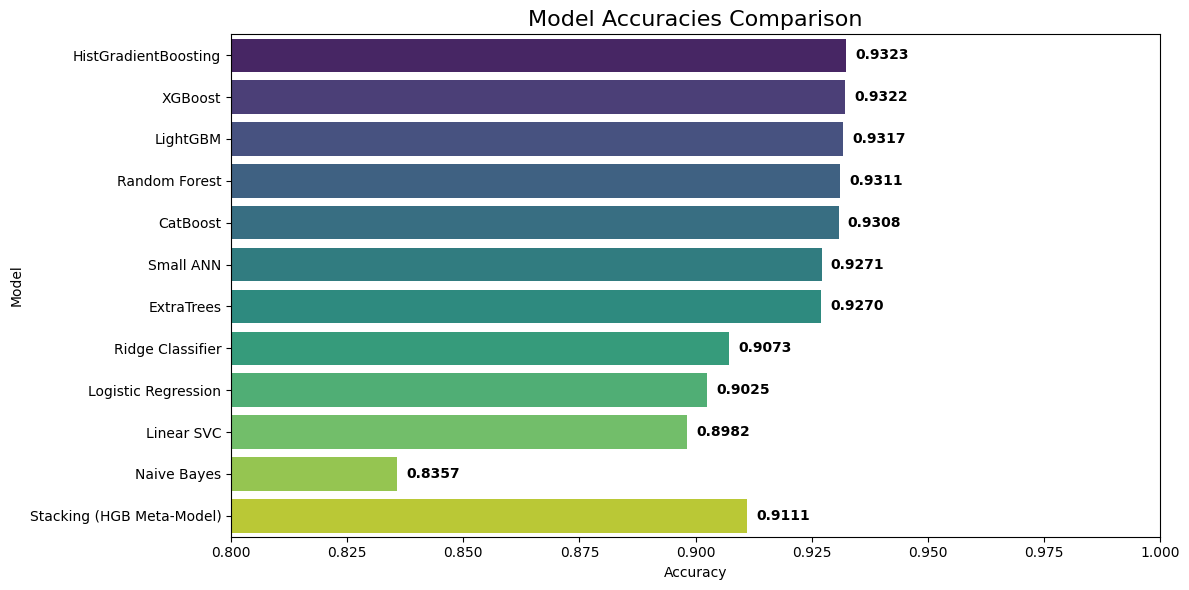

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract names and accuracies
model_names = [name for name, acc in model_accuracies]
accuracies = [acc for name, acc in model_accuracies]

# Add stacking model at the end
model_names.append("Stacking (HGB Meta-Model)")
accuracies.append(accuracy_score(y_test, pred_stack))

# Set figure size
plt.figure(figsize=(12,6))

# Create barplot
sns.barplot(x=accuracies, y=model_names, palette="viridis")

# Add title and labels
plt.title("Model Accuracies Comparison", fontsize=16)
plt.xlabel("Accuracy")
plt.xlim(0.8, 1)  # Assuming accuracies are mostly high
plt.ylabel("Model")

# Show value on each bar
for i, v in enumerate(accuracies):
    plt.text(v + 0.002, i, f"{v:.4f}", color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


**Model Metrics**

                        Model  Accuracy  Precision    Recall  F1-Score
0        HistGradientBoosting  0.932300   0.887840  0.883783  0.885807
1                     XGBoost  0.932172   0.888870  0.881973  0.885408
2                    LightGBM  0.931660   0.887866  0.881283  0.884562
3               Random Forest  0.931096   0.884108  0.883956  0.884032
4                    CatBoost  0.930763   0.886648  0.879386  0.883002
5                   Small ANN  0.927100   0.876862  0.877921  0.877391
6                  ExtraTrees  0.926972   0.846373  0.921459  0.882321
7   Stacking (HGB Meta-Model)  0.911066   0.787356  0.959910  0.865113
8            Ridge Classifier  0.907275   0.880206  0.796276  0.836140
9         Logistic Regression  0.902485   0.782811  0.929735  0.849970
10                 Linear SVC  0.898156   0.810661  0.857488  0.833417
11                Naive Bayes  0.835707   0.700549  0.780757  0.738482


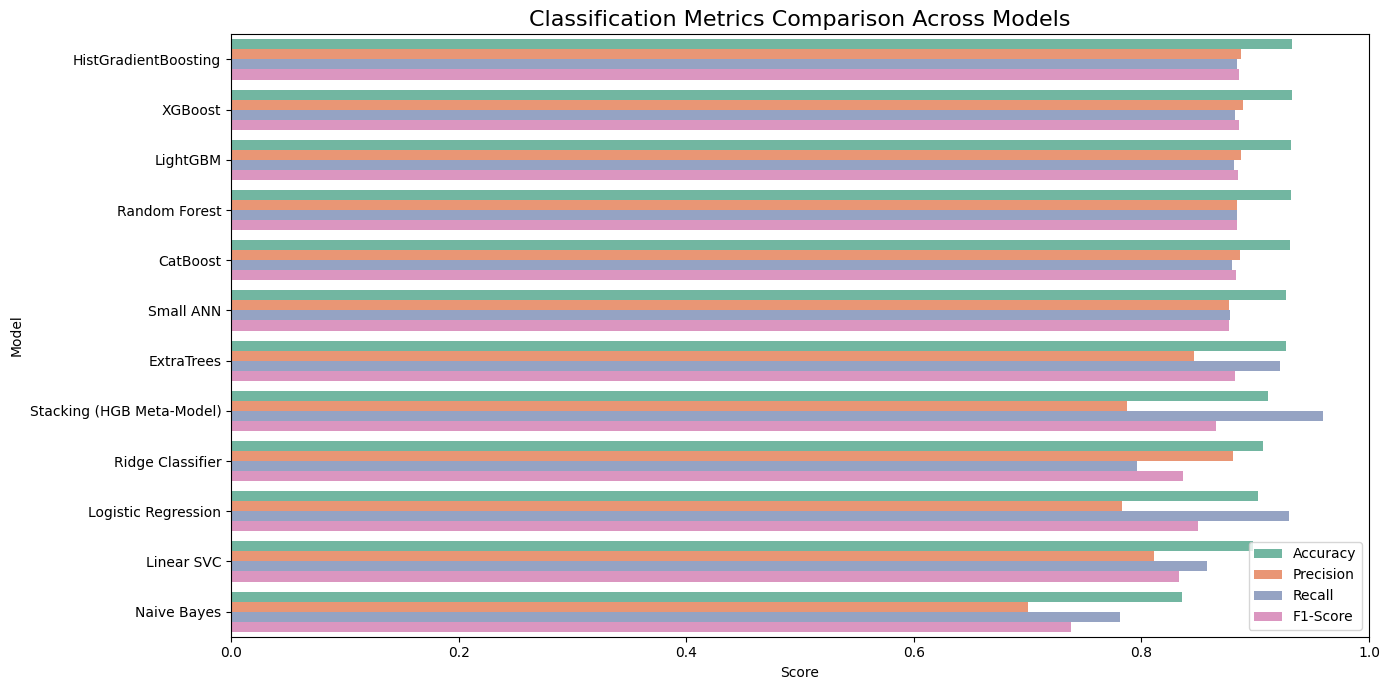

In [160]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of models and predictions
model_preds = [
    ("Random Forest", preds_rf),
    ("XGBoost", preds_xgb),
    ("CatBoost", preds_ctb),
    ("LightGBM", preds_lgbm),
    ("Logistic Regression", preds_lr),
    ("Linear SVC", preds_linsvc),
    ("HistGradientBoosting", preds_hgb),
    ("ExtraTrees", preds_et),
    ("Naive Bayes", model_nb.predict(X_test_num)),
    ("Small ANN", model_ann.predict(X_test)),
    ("Ridge Classifier", model_ridge.predict(X_test)),
    ("Stacking (HGB Meta-Model)", pred_stack)
]

# Compute metrics
metrics_list = []
for name, preds in model_preds:
    metrics_list.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1-Score": f1_score(y_test, preds)
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Sort by Accuracy
metrics_df = metrics_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

print(metrics_df)

# -----------------------------
# Visualization
# -----------------------------
plt.figure(figsize=(14,7))
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

sns.barplot(data=metrics_melted, x="Score", y="Model", hue="Metric", palette="Set2")
plt.title("Classification Metrics Comparison Across Models", fontsize=16)
plt.xlabel("Score")
plt.xlim(0,1)
plt.ylabel("Model")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [161]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

                   Model  Accuracy  Precision    Recall        F1
6   HistGradientBoosting  0.932300   0.887840  0.883783  0.885807
1                XGBoost  0.932172   0.888870  0.881973  0.885408
3               LightGBM  0.931660   0.887866  0.881283  0.884562
0          Random Forest  0.931096   0.884108  0.883956  0.884032
2               CatBoost  0.930763   0.886648  0.879386  0.883002
7             ExtraTrees  0.926972   0.846373  0.921459  0.882321
9              Small ANN  0.927100   0.876862  0.877921  0.877391
11          Stacking HGB  0.911066   0.787356  0.959910  0.865113
4    Logistic Regression  0.902485   0.782811  0.929735  0.849970
10      Ridge Classifier  0.907275   0.880206  0.796276  0.836140
5             Linear SVC  0.898156   0.810661  0.857488  0.833417
8            Naive Bayes  0.835707   0.700549  0.780757  0.738482


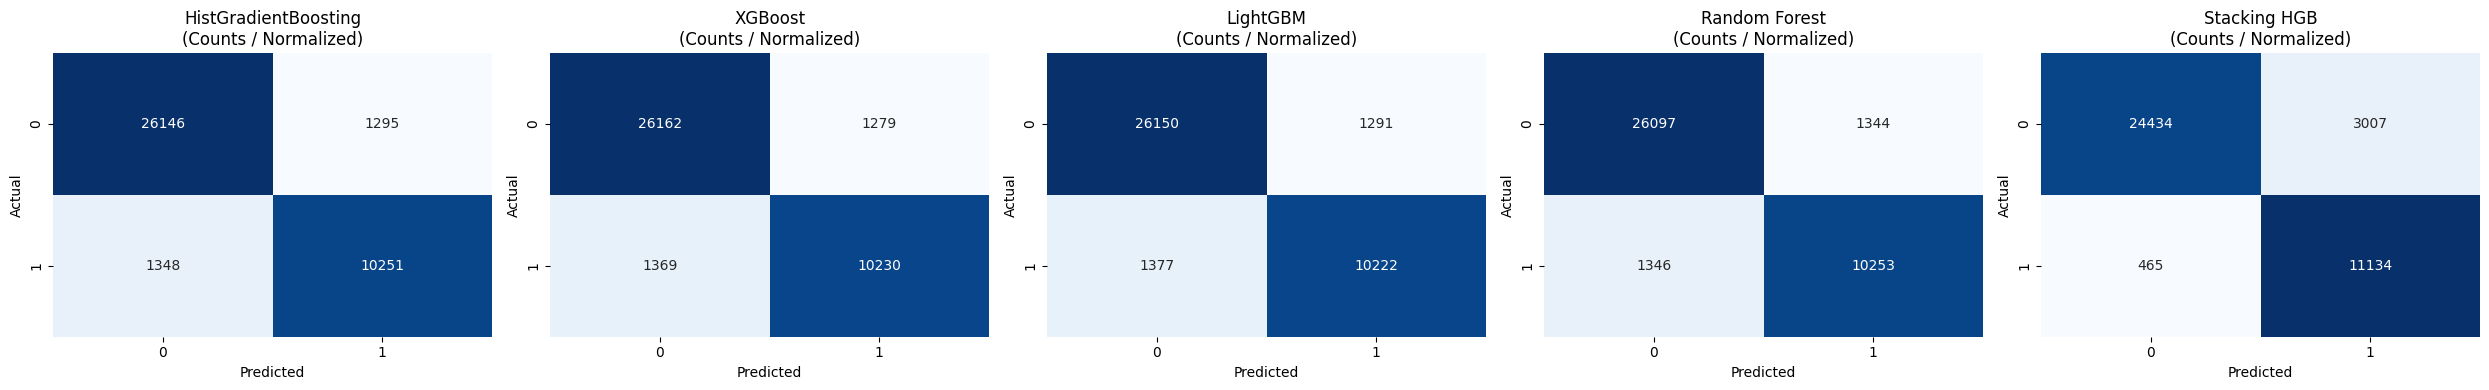

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# List of models and predictions
model_preds = [
    preds_rf,
    preds_xgb,
    preds_ctb,
    preds_lgbm,
    preds_lr,
    preds_linsvc,
    preds_hgb,
    preds_et,
    model_nb.predict(X_test_num),
    model_ann.predict(X_test),
    model_ridge.predict(X_test),
    pred_stack
]

model_names = [
    "Random Forest",
    "XGBoost",
    "CatBoost",
    "LightGBM",
    "Logistic Regression",
    "Linear SVC",
    "HistGradientBoosting",
    "ExtraTrees",
    "Naive Bayes",
    "Small ANN",
    "Ridge Classifier",
    "Stacking HGB"
]

# -----------------------------
# Compute metrics for each model
# -----------------------------
metrics_list = []
for name, preds in zip(model_names, model_preds):
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    metrics_list.append((name, acc, prec, rec, f1))

# Create DataFrame for metrics
import pandas as pd
df_metrics = pd.DataFrame(metrics_list, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
df_metrics = df_metrics.sort_values(by="F1", ascending=False)  # sort by F1 or choose another metric
print(df_metrics)

# -----------------------------
# Plot confusion matrices
# -----------------------------
def plot_conf_matrices(y_true, model_preds, model_names, class_labels=[0,1]):
    """
    Plots confusion matrices for multiple models side by side.
    """
    n_models = len(model_preds)
    plt.figure(figsize=(5*n_models, 4))

    for i, (preds, name) in enumerate(zip(model_preds, model_names)):
        cm = confusion_matrix(y_true, preds, labels=class_labels)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalized
        plt.subplot(1, n_models, i+1)
        sns.heatmap(cm_norm, annot=cm, fmt='g', cmap='Blues', cbar=False,
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.title(f"{name}\n(Counts / Normalized)", fontsize=12)
        plt.ylabel("Actual")
        plt.xlabel("Predicted")

    plt.tight_layout()
    plt.show()

# Plot for top 4 models plus stacking for clarity
top_models = df_metrics["Model"].values[:4].tolist() + ["Stacking HGB"]
top_preds = [model_preds[model_names.index(name)] for name in top_models]

plot_conf_matrices(y_test, top_preds, top_models)

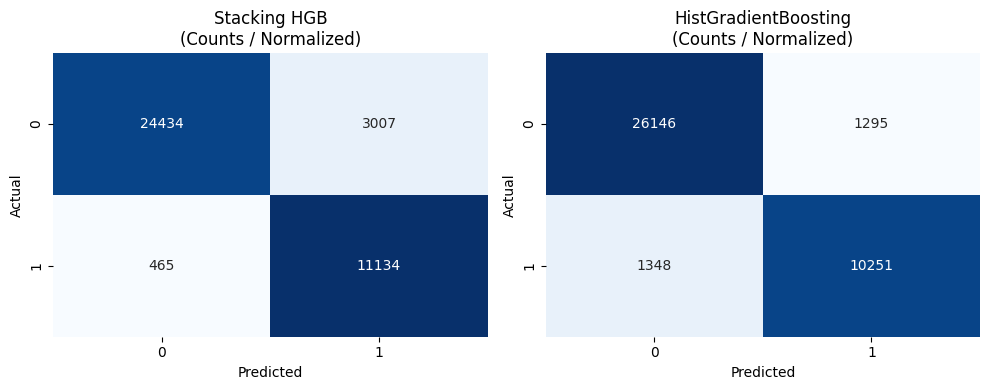

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# List of models and their predictions
model_names = ["Stacking HGB", "HistGradientBoosting"]
model_preds = [pred_stack, preds_hgb]  # make sure these are the predictions from your test set

def plot_conf_matrices(y_true, model_preds, model_names, class_labels=[0,1]):
    """
    Plots confusion matrices for multiple models side by side.
    """
    n_models = len(model_preds)
    plt.figure(figsize=(5*n_models, 4))

    for i, (preds, name) in enumerate(zip(model_preds, model_names)):
        cm = confusion_matrix(y_true, preds, labels=class_labels)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalized
        plt.subplot(1, n_models, i+1)
        sns.heatmap(cm_norm, annot=cm, fmt='g', cmap='Blues', cbar=False,
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.title(f"{name}\n(Counts / Normalized)", fontsize=12)
        plt.ylabel("Actual")
        plt.xlabel("Predicted")

    plt.tight_layout()
    plt.show()

# Plot confusion matrices
plot_conf_matrices(y_test, model_preds, model_names)


**Saving and Downloading the Models**

In [173]:
import os
import pickle
import shutil
import numpy as np

# -----------------------------
# 1. Replace lambda with named function
# -----------------------------
from sklearn.preprocessing import FunctionTransformer

def to_string(X):
    return X.astype(str)

# Rebuild categorical transformer with named function
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

numerical_cols = X.select_dtypes(exclude=['object']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numerical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy='constant', fill_value=0))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy='constant', fill_value='missing_value')),
    ("to_string", FunctionTransformer(to_string)),
    ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor_fixed = ColumnTransformer([
    ("num", numerical_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# -----------------------------
# 2. Rebuild pipelines with fixed preprocessor
# -----------------------------
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

final_model_rf = Pipeline([("preprocessor", preprocessor_fixed), ("model", final_model_rf.named_steps["model"])])
final_model_xgb = Pipeline([("preprocessor", preprocessor_fixed), ("model", final_model_xgb.named_steps["model"])])
final_model_ctb = Pipeline([("preprocessor", preprocessor_fixed), ("model", final_model_ctb.named_steps["model"])])
final_model_lgbm = Pipeline([("preprocessor", preprocessor_fixed), ("model", final_model_lgbm.named_steps["model"])])
final_model_lr = Pipeline([("preprocessor", preprocessor_fixed), ("model", final_model_lr.named_steps["model"])])
final_model_linsvc = Pipeline([("preprocessor", preprocessor_fixed), ("model", final_model_linsvc.named_steps["model"])])
final_model_hgb = Pipeline([("preprocessor", preprocessor_fixed), ("model", final_model_hgb.named_steps["model"])])
final_model_et = Pipeline([("preprocessor", preprocessor_fixed), ("model", final_model_et.named_steps["model"])])
model_ridge = Pipeline([("preprocessor", preprocessor_fixed), ("model", model_ridge.named_steps["model"])])
model_ann = Pipeline([("preprocessor", preprocessor_fixed), ("mlp", model_ann.named_steps["mlp"])])

# GaussianNB uses only numeric, save separately
# -----------------------------
# 3. Save all models using pickle
# -----------------------------
model_dir = "trained_models_pickle"
os.makedirs(model_dir, exist_ok=True)

all_models = {
    "final_model_rf": final_model_rf,
    "final_model_xgb": final_model_xgb,
    "final_model_ctb": final_model_ctb,
    "final_model_lgbm": final_model_lgbm,
    "final_model_lr": final_model_lr,
    "final_model_linsvc": final_model_linsvc,
    "final_model_hgb": final_model_hgb,
    "final_model_et": final_model_et,
    "model_nb": model_nb,
    "model_ann": model_ann,
    "model_ridge": model_ridge,
    "stacking_hgb": meta_model
}

for name, model in all_models.items():
    filepath = os.path.join(model_dir, f"{name}.pkl")
    with open(filepath, "wb") as f:
        pickle.dump(model, f)
    print(f"Saved {name} -> {filepath}")

# -----------------------------
# 4. Zip models for download
# -----------------------------
shutil.make_archive("trained_models_pickle", 'zip', model_dir)
print("All models zipped as trained_models_pickle.zip")


Saved final_model_rf -> trained_models_pickle/final_model_rf.pkl
Saved final_model_xgb -> trained_models_pickle/final_model_xgb.pkl
Saved final_model_ctb -> trained_models_pickle/final_model_ctb.pkl
Saved final_model_lgbm -> trained_models_pickle/final_model_lgbm.pkl
Saved final_model_lr -> trained_models_pickle/final_model_lr.pkl
Saved final_model_linsvc -> trained_models_pickle/final_model_linsvc.pkl
Saved final_model_hgb -> trained_models_pickle/final_model_hgb.pkl
Saved final_model_et -> trained_models_pickle/final_model_et.pkl
Saved model_nb -> trained_models_pickle/model_nb.pkl
Saved model_ann -> trained_models_pickle/model_ann.pkl
Saved model_ridge -> trained_models_pickle/model_ridge.pkl
Saved stacking_hgb -> trained_models_pickle/stacking_hgb.pkl
All models zipped as trained_models_pickle.zip


In [170]:
files.download("trained_models_pickle.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Load the Final Model**

In [174]:
import pickle

# Load saved stacking HGB model
with open("trained_models_pickle/stacking_hgb.pkl", "rb") as f:
    stacking_hgb = pickle.load(f)

print("Stacking HGB model loaded successfully!")


Stacking HGB model loaded successfully!
